In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

from PTA import PTA
from likelihood import get_likelihood_obj

import miscMCMC.samplers.jax_ptmcmc as ptmcmc

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

In [2]:
# make PTA and likelihood objects
pta = PTA(Np=1, Tspan_yr=15., Nf=5, model_wn=True, model_rn=True, model_gwb=False, model_cw=False, seed=47)
l = get_likelihood_obj(pta)

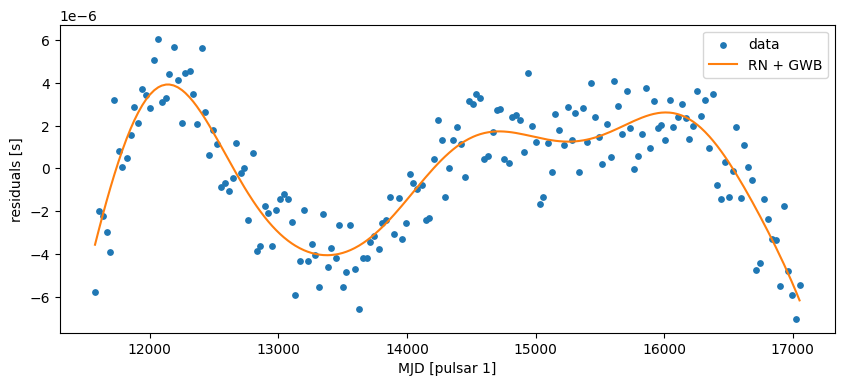

In [3]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
if pta.model_gwb or pta.model_rn:
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if pta.model_cw:
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (pta.model_gwb or pta.model_rn) and pta.model_cw:
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [4]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[pta.efac_ndxs]
    rn_hypers = x[pta.rn_ndxs]
    # gwb_hypers = x[pta.gwb_ndxs]
    # cw_psr_params = x[pta.cw_psr_ndxs]
    # psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn(rn_hypers, a)
    # lnprior_val += l.psr_dist_lnprior(psr_dists)

    # likelihood
    # a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(efacs, a)

    return lnprior_val + lnlike_val


vectorized_lnpost = jit(vmap(lnpost))

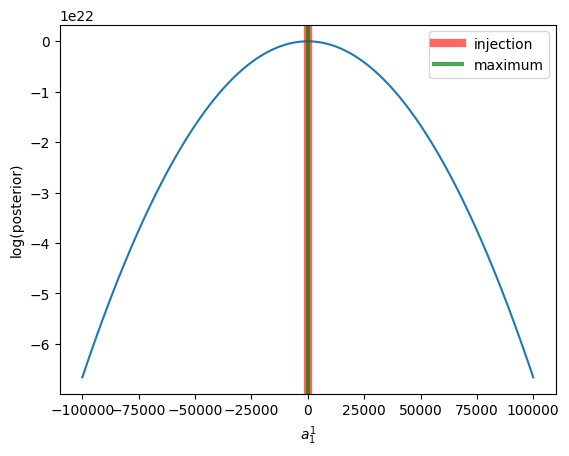

In [5]:
# plot cross-section of posterior
param_ndx = 3
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [6]:
@jit
def pt_lnpost(x, temperature=1.):
    return lnpost(x) / temperature

In [25]:
num_samples = int(1e7)
num_chains = 20
states, lnposts, temperature_ladder = ptmcmc.ptmcmc_sampler(num_samples=num_samples,
                                                            num_chains=num_chains,
                                                            logpdf_func=pt_lnpost,
                                                            x0=pta.x_inj,
                                                            x_mins=pta.x_mins,
                                                            x_maxs=pta.x_maxs,
                                                            temperature_ladder=1.2**jnp.arange(num_chains),
                                                            Fisher_jump_weight=20.,
                                                            DE_jump_weight=0.,
                                                            PT_swap_weight=20.,
                                                            Fisher_update_rate=0.05,
                                                            DE_history_with_Fisher=False,
                                                            seed=21)

jump acceptance rates

Fisher: [0.51600003 0.53800005 0.56100005 0.583      0.60300004 0.623
 0.64100003 0.65900004 0.67600006 0.69200003 0.707      0.72200006
 0.735      0.748      0.75900006 0.77000004 0.78000003 0.79
 0.799      0.80700004]

DE: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]

PT swap: [0.748      0.75100005 0.753      0.75600004 0.758      0.75900006
 0.76100004 0.762      0.76400006 0.76500005 0.76600003 0.767
 0.768      0.76900005 0.771      0.771      0.772      0.77300006
 0.771             nan]



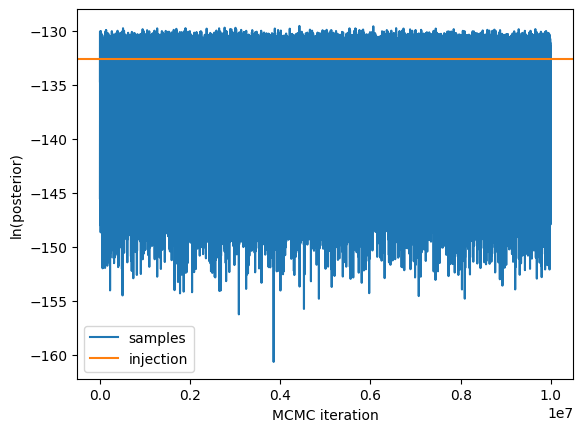

In [26]:
# plot posterior values
plt.plot(lnposts[:, 0], label='samples')
plt.axhline(lnpost(pta.x_inj), color='C1', label='injection')
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.legend()
plt.show()

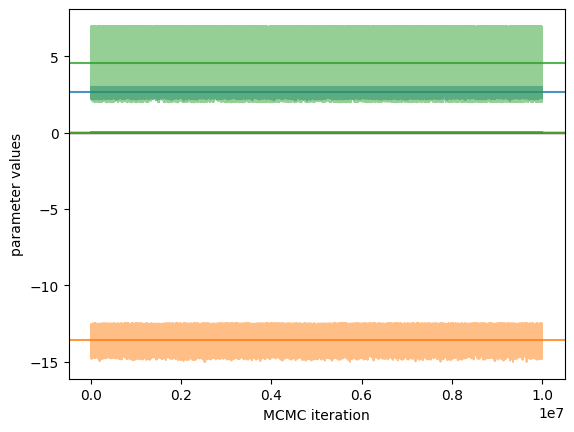

In [27]:
# trace plot
for i in range(pta.ndim):
    plt.plot(states[:, 0, i], color=f'C{i}', alpha=0.5)
    plt.axhline(pta.x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.show()

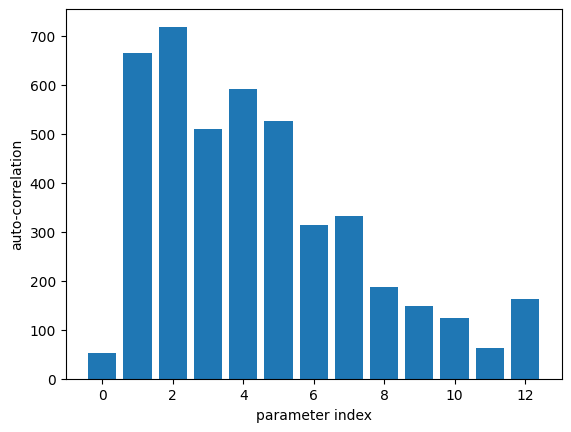

In [28]:
# plot auto-correlations
auto_corrs = np.array([integrated_time(states[:, 0, i])[0] for i in range(pta.ndim)])
plt.bar(np.arange(pta.ndim), auto_corrs)
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

In [29]:
states.shape[0] / auto_corrs.max()

13913.047923819167

In [30]:
hmc_samples = np.load('hmc_samples1.npy')

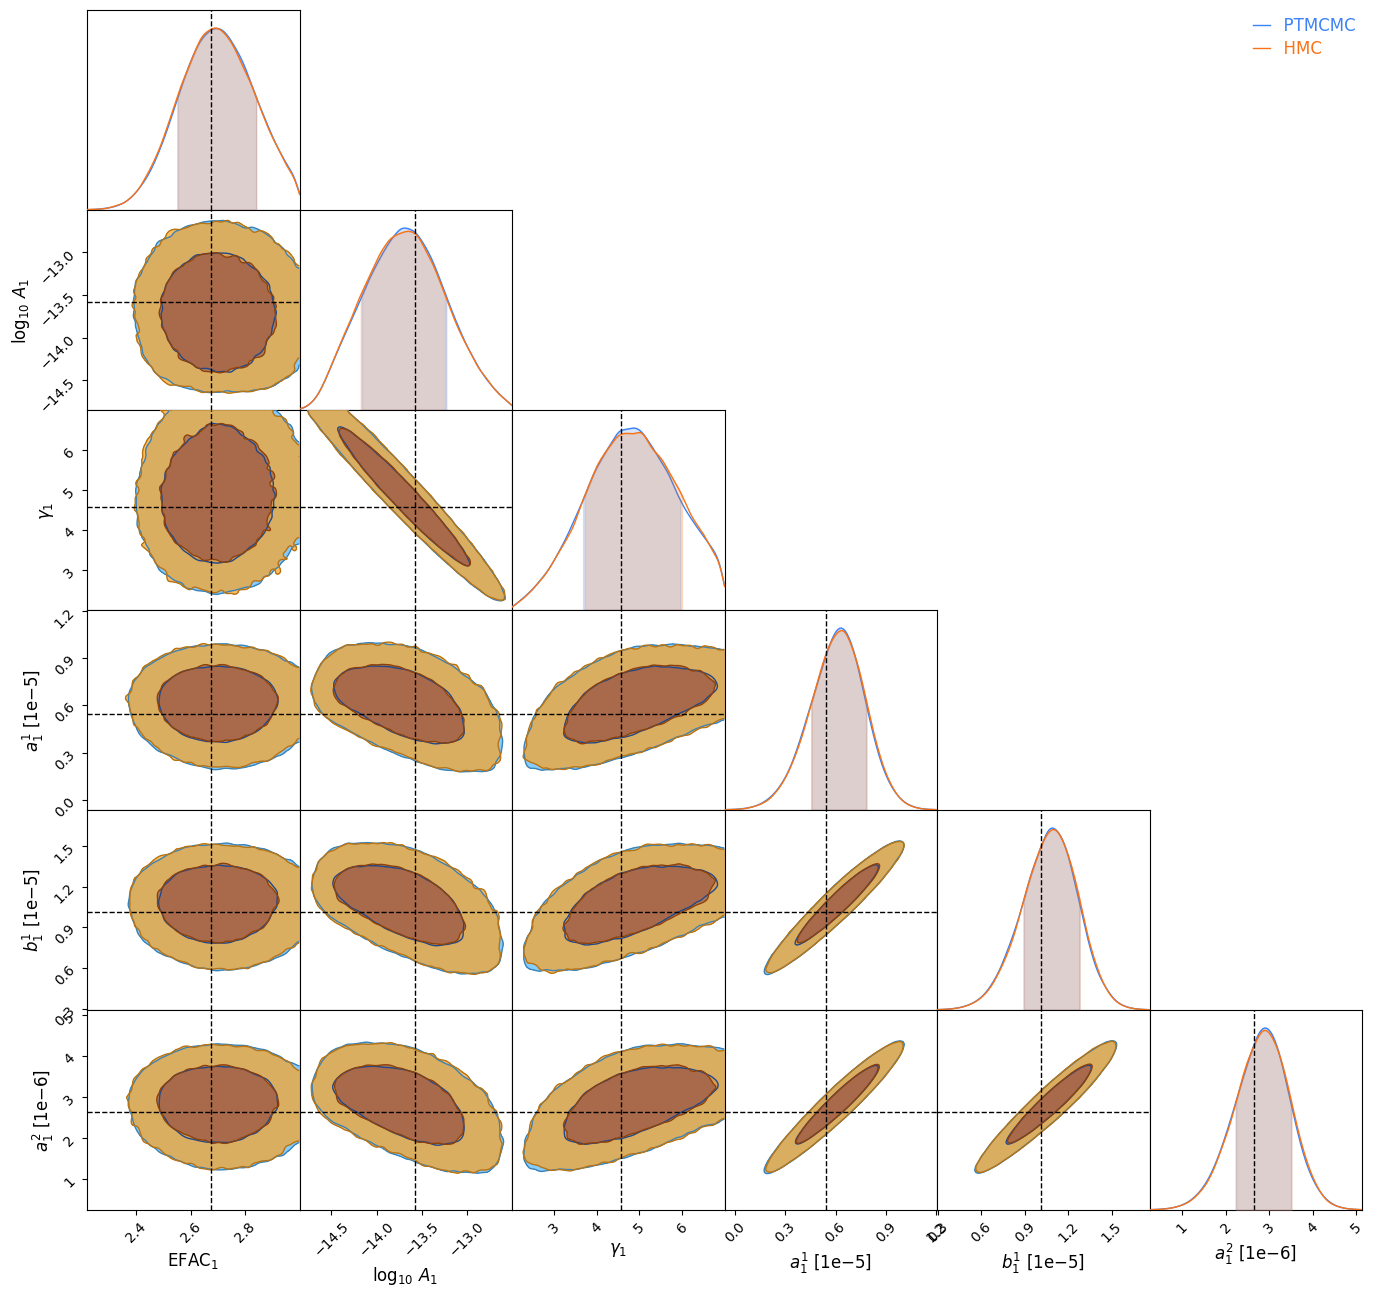

In [31]:
# corner plot
ndxs = np.r_[:6]
df = pd.DataFrame(states[num_samples//10::10, 0], columns=pta.x_labels)
hmc_df = pd.DataFrame(hmc_samples, columns=pta.x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='PTMCMC'))
c.add_chain(Chain(samples=hmc_df.iloc[:, ndxs], name='HMC', color='orange'))
c.add_truth(Truth(location={name: val for name, val in zip(pta.x_labels, pta.x_inj)}))
fig = c.plotter.plot()

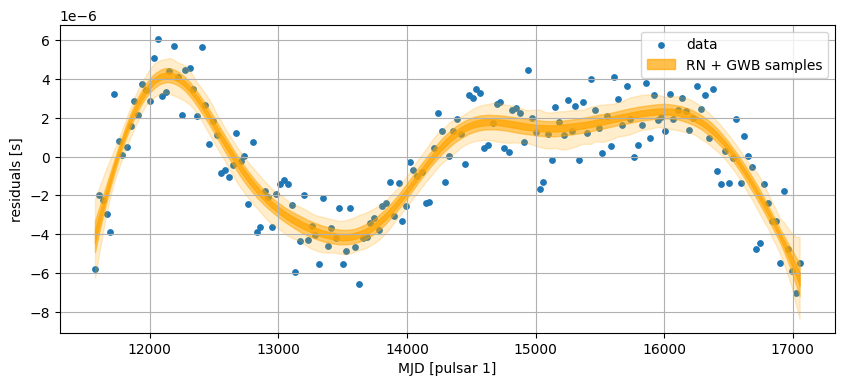

In [32]:
# Bayesogram
psr_ndx = 0
samples = states[:, 0]
fair_draw_ndxs = np.random.choice(samples.shape[0], (1000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.1, 10., 30.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

# Bayesogram for RN + GWB
if pta.model_rn or pta.model_gwb:
    rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                            np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                            color='orange', alpha=alpha, label='RN + GWB samples')
    # rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]

# Bayesogram for CW
if pta.model_cw:
    a_cws = np.array([pta.get_CW_coefficients(samples[ndx, pta.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
    cw_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ a_cw for a_cw in a_cws])
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                            np.percentile(cw_signals, 100. - percentile, axis=0),
                            color='green', alpha=alpha, label='CW samples')
    # cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]

# Bayesogram for RN + GWB + CW
if pta.model_rn and pta.model_gwb and pta.model_cw:
    signals = cw_signals + rn_gwb_signals
    for percentile, alpha in zip(percentile_layers, alphas):
        if percentile != percentile_layers[-1]:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha)
        else:
            plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                            np.percentile(signals, 100. - percentile, axis=0),
                            color='purple', alpha=alpha, label='RN + GWB + CW samples')
    # plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C1', label='RN + GWB + CW injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()